## **Deep Learning**

----

**Author**:  <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>

\\

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

\\

This is a notebook for the handwritten digit classification problem based on the classical Modified National Institute of Standards and Technology (MNIST) database. It uses three neural networks to address this problem: ```SNN500``` by <a href="https://github.com/AvivSham/Pytorch-MNIST-colab">Aviv Shamsian</a>, ```CNN3L``` by <a href="https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118">Nutan</a>, and ```LeNet-5``` by <a href="https://github.com/bollakarthikeya/LeNet-5-PyTorch/blob/master/lenet5_gpu.py">Bolla Karthikeya</a>. 




In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import time

In [2]:
# This function obtains the number of trainable parameters of the 
# model/network.
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total trainable params: {total_params}")
    return total_params

In [3]:
# Just visualising some images
def visualise_images(img, lab, t):
   fig = plt.figure()
   for i in range(6):
     plt.subplot(2,3,i+1)
     plt.tight_layout()
     plt.imshow(img[i][0], cmap='gray', interpolation='none')
     plt.title("{} - class: {}".format(t,lab[i]))
     plt.xticks([])
     plt.yticks([])

## **Define important variables**
----

Here, we define the number of classes and also some hyper-parameters.

In [4]:
num_classes = 10 # Number of output classes, discrete range [0,9]

# Hyper-parameters
num_epochs = 20 # Number of epochs
batch_size = 100 # The size of input data took for one iteration
lr = 1e-3 # Learning rate

## **MNIST dataset**
----

Downloading and handling the MNIST dataset. Note that, as the PyTorch documentation, <a href="https://pytorch.org/vision/stable/transforms.html">```transforms.ToTensor()```</a> "converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8".

In [5]:
# Downloading MNIST dataset
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

print('#'*20)
print('Training dataset: ', train_data)
print('Test dataset: ', test_data)

####################
Training dataset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Test dataset:  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# Wrap an iterable around the dataset to enable easy access to the samples.
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                       batch_size = batch_size, 
                                       shuffle = False)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device is: ', device)

Device is:  cuda:0


## **Looking at the datasets**

----

Just taking a quick look at the datasets.



One batch - training dataset: torch.Size([100, 1, 28, 28])

Each image of the batch:
Image: 0 - Input shape: torch.Size([1, 28, 28]) - Class: 7
Image: 1 - Input shape: torch.Size([1, 28, 28]) - Class: 9
Image: 2 - Input shape: torch.Size([1, 28, 28]) - Class: 0
Image: 3 - Input shape: torch.Size([1, 28, 28]) - Class: 7
Image: 4 - Input shape: torch.Size([1, 28, 28]) - Class: 7
Image: 5 - Input shape: torch.Size([1, 28, 28]) - Class: 6
Image: 6 - Input shape: torch.Size([1, 28, 28]) - Class: 3
Image: 7 - Input shape: torch.Size([1, 28, 28]) - Class: 0
Image: 8 - Input shape: torch.Size([1, 28, 28]) - Class: 7
Image: 9 - Input shape: torch.Size([1, 28, 28]) - Class: 6
Image: 10 - Input shape: torch.Size([1, 28, 28]) - Class: 6
Image: 11 - Input shape: torch.Size([1, 28, 28]) - Class: 1
Image: 12 - Input shape: torch.Size([1, 28, 28]) - Class: 3
Image: 13 - Input shape: torch.Size([1, 28, 28]) - Class: 4
Image: 14 - Input shape: torch.Size([1, 28, 28]) - Class: 4
Image: 15 - Input shape: 

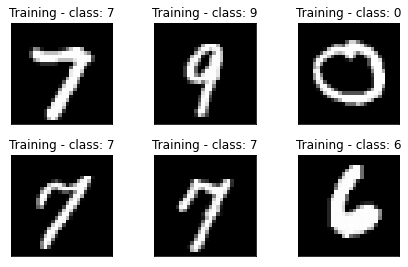

In [7]:
batch_train = enumerate(train_gen)
batch_idx, (batch_train_data, batch_train_classes) = next(batch_train)
print('One batch - training dataset:', batch_train_data.shape)

print('\nEach image of the batch:')
for i in range(batch_train_classes.shape[0]):
  print('Image: {} - Input shape: {} - Class: {}'.format(i, batch_train_data[i].shape, batch_train_classes[i]))
  if i == (batch_train_classes.shape[0]-1):
    print('The "image" itself: ', batch_train_data[i])

visualise_images(batch_train_data, batch_train_classes, 'Training')

One batch - test dataset: torch.Size([100, 1, 28, 28])


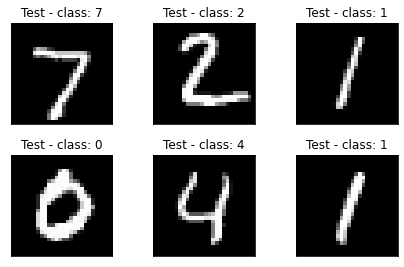

In [8]:
batch_test = enumerate(test_gen)
batch_idx, (batch_test_data, batch_test_classes) = next(batch_test)
print('One batch - test dataset:', batch_test_data.shape)

visualise_images(batch_test_data, batch_test_classes, 'Test' )

## **Neural networks**

----

We use three neural networks in order to compare their performances based on the accuracy of the test dataset. The first is ```SNN500``` which is a shallow neural network (SNN) with a single hidden layer containing 500 neurons (traditionally, a model/network is considered shallow when it has one or two hidden layers). 

<img src="https://scipython.com/static/media/uploads/blog/shallow-neural-net/snn.png" width="300"/>

\\

The second network is ```CNN3L``` which is also considered an SNN because it has two hidden (convolutional) layers and the output layer 

\\

The third network is the classical <a href="https://ieeexplore.ieee.org/document/726791">```LeNet-5```</a> DNN with five layers where four are hidden ones.





In [9]:
class SNN500(nn.Module):
  def __init__(self, input_sz, hidden_sz, num_clas):
    super(SNN500,self).__init__()
    self.fc1 = nn.Linear(input_sz, hidden_sz)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_sz, num_clas)
  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [10]:
class CNN3L(nn.Module):
    def __init__(self, num_clas):
        super(CNN3L, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),                
        )
        # Fully-connected layer
        self.out = nn.Linear(32 * 7 * 7, num_clas)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # Flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output   

In [11]:
class LeNet5(nn.Module):          
    def __init__(self, num_clas):     
        super(LeNet5, self).__init__()
        # Convolution 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2) 
        # Fully-connected layers
        self.fc1 = nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = nn.Linear(84, num_clas)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        # Convolve, then perform ReLU non-linearity
        x = nn.functional.relu(self.conv1(x))  
        # Max-pooling with 2x2 grid 
        x = self.max_pool_1(x) 
        # Convolve, then perform ReLU non-linearity
        x = nn.functional.relu(self.conv2(x))
        # Max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # First flatten 'max_pool_2_out' to contain 16*5*5 columns
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        return x

## **Select the model**

----

Now, we can select one of the models/networks to train and evaluate.

In [12]:
opt = input("Enter your choice:")
if opt =='1':
  input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
  hidden_size_tb = 500 # Number of nodes at hidden layer
  net = SNN500(input_size, hidden_size_tb, num_classes)
  opt_name = 'SNN500'
  print("You selected SNN500!")
elif opt =='2':
  net = CNN3L(num_classes)
  opt_name = 'CNN3L'
  print("You selected CNN3L!")
elif opt =='3':
  net = LeNet5(num_classes)
  opt_name = 'LeNet-5'
  print("You selected LeNet-5!")
else:
  print("Invalid Option!")

if torch.cuda.is_available():
   net.to(device)

Enter your choice:3
You selected LeNet-5!


## **Define loss function and optimiser**

----

The <a href="https://github.com/AvivSham/Pytorch-MNIST-colab">CrossEntropyLoss</a> function combines LogSoftmax and NLLLoss in one single class. The learning rate has already been defined.

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

print('Checking trainable parameters: {}'.format(count_parameters(net)))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    150     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   48000    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total trainable params: 61706
Checking trainable parameters: 61706


## **Training phase**

----

Now, we can train the model.

In [14]:
train_losses = []
train_acc = []
train_time_init = time.time()
for epoch in range(num_epochs):
  net.train() 
  running_loss = 0.0
  running_corrects = 0
  for images,labels in train_gen: # Iterate over data: begin
    if opt == '1':
      images = Variable(images.view(-1,28*28)).to(device) # Send to GPU
    elif (opt == '2') or (opt == '3'):
      images = Variable(images).to(device) # Send to GPU
    
    labels = Variable(labels).to(device) # Send to GPU
    optimizer.zero_grad()
    with torch.set_grad_enabled(True):
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data)
  # Iterate over data: end

  epoch_loss = running_loss / len(train_data)
  epoch_acc = running_corrects.double() / len(train_data)  
  print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.4f'
                 %(epoch+1, num_epochs, epoch_loss, epoch_acc))
  
  train_losses.append(epoch_loss)
  train_acc.append(epoch_acc) 

train_time_end = time.time() - train_time_init    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/20], Loss: 0.3328, Accuracy: 0.8977
Epoch [2/20], Loss: 0.0870, Accuracy: 0.9737
Epoch [3/20], Loss: 0.0626, Accuracy: 0.9808
Epoch [4/20], Loss: 0.0505, Accuracy: 0.9849
Epoch [5/20], Loss: 0.0413, Accuracy: 0.9874
Epoch [6/20], Loss: 0.0345, Accuracy: 0.9887
Epoch [7/20], Loss: 0.0289, Accuracy: 0.9907
Epoch [8/20], Loss: 0.0256, Accuracy: 0.9914
Epoch [9/20], Loss: 0.0221, Accuracy: 0.9929
Epoch [10/20], Loss: 0.0203, Accuracy: 0.9934
Epoch [11/20], Loss: 0.0186, Accuracy: 0.9938
Epoch [12/20], Loss: 0.0149, Accuracy: 0.9950
Epoch [13/20], Loss: 0.0131, Accuracy: 0.9957
Epoch [14/20], Loss: 0.0131, Accuracy: 0.9954
Epoch [15/20], Loss: 0.0112, Accuracy: 0.9964
Epoch [16/20], Loss: 0.0099, Accuracy: 0.9967
Epoch [17/20], Loss: 0.0091, Accuracy: 0.9972
Epoch [18/20], Loss: 0.0090, Accuracy: 0.9967
Epoch [19/20], Loss: 0.0074, Accuracy: 0.9977
Epoch [20/20], Loss: 0.0073, Accuracy: 0.9977


## **Training phase: results**
----

Just showing the loss and accuracy during the training phase.



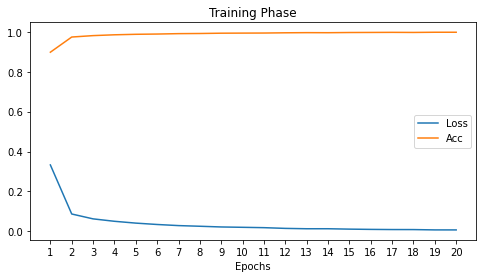

In [15]:
x = range(1,len(train_losses)+1)

plt.figure(figsize=(8,4))
plt.title("Training Phase")
plt.plot(x,train_losses,label="Loss")
plt.plot(x,train_acc,label="Acc")
plt.xticks(range(1,len(x)+1))
plt.xlabel("Epochs")
plt.legend()
plt.show()

## **Inference phase**

----

In the inference phase, we measure the performance of our model. 

In [16]:
am_training = net.training
print('Am I training? ', am_training)
net.eval()
am_training = net.training
print('Am I training? ', am_training)
inference_loss = 0.0
inference_corrects = 0

infer_time_init = time.time()
with torch.no_grad():
  for images,labels in test_gen: # Iterate over data: begin
      if opt == '1':
        images = Variable(images.view(-1,28*28)).to(device) # Send to GPU
      elif opt == '2' or opt == '3':
        images = Variable(images).to(device) # Send to GPU
      
      labels = labels.to(device) # Send to GPU
      outputs_infer = net(images)
      _, preds_infer = torch.max(outputs_infer,1)
      loss_infer = loss_function(outputs_infer, labels)

      inference_loss += loss_infer.item() * images.size(0)
      inference_corrects += torch.sum(preds_infer == labels.data)
  # Iterate over data: end

final_inference_loss = inference_loss / len(test_data)
final_inference_acc = inference_corrects.double() / len(test_data)

infer_time_end = time.time() - infer_time_init
print('\nTraining and inference in {:.0f}m {:.0f}s  OR  {:.0f}s'.format(
        (train_time_end + infer_time_end) // 60, 
        (train_time_end + infer_time_end) % 60,
         train_time_end + infer_time_end))

print('\nLoss of {}: {:.4f}'.format(opt_name, final_inference_loss))
print()
print('Accuracy of {}: {:.4f}'.format(opt_name, final_inference_acc))

Am I training?  True
Am I training?  False

Training and inference in 3m 18s  OR  198s

Loss of LeNet-5: 0.0502

Accuracy of LeNet-5: 0.9885
